# Torch Dataset Utilities

"torchdatasetutils" produces torch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) classes and utility functions for several imaging datasets.  This currently includes sets of images and annotations from [CVAT](https://github.com/openvinotoolkit/cvat), [COCO dataset](https://cocodataset.org/).  "torchdatasetutil" uses an s3 object storage to hold dataset data.  This enables training and test to be performed on nodes different from where the dataset is stored with application defined credentials.  It uses torch PyTorch worker threads to prefetch data for efficient GPU or CPU training and inference.

"torchdatasetutils" takes as an input the [pymlutil](https://pypi.org/project/pymlutil/).s3 object to access the object storage.

Two json or yaml dictionaries are loaded from the object storage to identify and process the dataset: the dataset description and class dictionary.  The the dataset description is unique for each type of dataset.  The class dictionary is common to all datasets and describes data transformation and data augmentation.

## Library structure
- pymlutil.s3: access to object torage
- [torchdatasetutil](https://pypi.org/project/torchdatasetutil/)
    - [gitcoco.getcoco](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/getcoco.py#L25): function to load the [COCO dataset](https://cocodataset.org/) from internet archives into object storage
    - [cocostore](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/cocostore.py)
        - [CocoStore](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/cocostore.py#L17): class providing a python iterator over the coco dataset in object storage
        - [CocoDataset](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/cocostore.py)" class implementing the pytorch [Dataset class](https://pytorch.org/docs/stable/data.html#dataset-types) for the CocoStore iterator
        - CreateCocoLoaders: function returning set of torch dataloders of CocoDatasets.
    - [imstore](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/imstore.py)
        - ImagesStore: class providing python iterator over sets of images for dataset inference.
        - ImagesDataset: Torch dataset derived class augmenting and extaracting random crops for training and test.
        - CreateImageLoaders: function returning set of torch dataloaders of ImagesDatasets.


In [94]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import cv2
from pymlutil.s3 import s3store, Connect
import ipywidgets as widgets

In [2]:
credentials = "creds.yaml"
s3, creds, s3def = Connect(credentials)
s3def

{'name': 'store',
 'type': 'trainer',
 'address': '198.211.145.1:30990',
 'tls': False,
 'sets': {'dataset': {'bucket': 'mllib',
   'prefix': 'data',
   'dataset_filter': ''},
  'trainingset': {'bucket': 'mllib',
   'prefix': 'training',
   'dataset_filter': ''},
  'model': {'bucket': 'mllib', 'prefix': 'model', 'dataset_filter': ''},
  'test': {'bucket': 'mllib', 'prefix': 'test', 'dataset_filter': ''}}}

## Create images dataset
The pymlutil module command line interface enables a local directory to be loaded into object storage. To load files organized in a local directory, execute
```cmd
python -m pymlutil -p -src <source directory> -dest <destination path>
```
The the -credentials default is 'creds.yaml' and -set default is 'dataset'.  In Jupyter, load a dataset of files as follows:

In [3]:
! python3 -m pymlutil -p -src tests/testimages -set dataset -dest testimages

PutDir: 100%|████████████████████████████████████| 3/3 [00:00<00:00, 101.21it/s]
pymluitil complete


To load files from python, call the pymlutil.s3.PutDir(self, bucket, path, setname) where path is the source path and setname is the destination object prefix.

In [23]:
dest = '{}/{}'.format(s3def['sets']['dataset']['prefix'], 'testimages')
s3.PutDir(s3def['sets']['dataset']['bucket'], 'dataset', dest)

PutDir: 0it [00:00, ?it/s]


True

### imstore dataset
torchdatasetutil.imstore ImagesStore produces an [iterator object](https://docs.python.org/3/c-api/iterator.html) from a set of images in an object store.  The image dataset_description is a json or yaml file definining the set of images to include in the ImageStore.

In [3]:
bucket = s3def['sets']['dataset']['bucket']
img_dataset_desc_file = 'data/lit/dataset.yaml'
img_dataset_desc = s3.GetDict(bucket,img_dataset_desc_file)
img_dataset_desc

{'bucket': 'mllib',
 'prefix': 'annotations/lit',
 'image_path': None,
 'image_pattern': '*.tif',
 'image_colorspace': 'grayscale',
 'label_path': None,
 'label_in_image_path': True,
 'label_pattern': '*_cls.png',
 'recursive': True}

### Class Dictionary [#ClassDictionary]()

"torchdatasetloader" expects a class_dictionary input.  The class dictionary defines a mapping between the dataset classes and the training classes.  "class_dictionary" has the following entries:
```json
{
    'input_channels':3,
    'input_type': "float32",
    'background': <background index>
    'ignore': <ignore index>
    'objects'[
        {
            'id': <dataset integer class index>
            'trainId': <training integer class index>
            'name': <string class name>
            'category': <string group name>
            'display': <true/false>
            'color':[<red:0-255>,<green:0-255>, <blue:0-255>]
        },
        ...
    ]
}
```

In [4]:
class_dictionary = 'model/crisplit/lit.json'
class_dictionary_example = s3.GetDict(s3def['sets']['dataset']['bucket'],class_dictionary)
class_dictionary_example

{'input_channels': 1,
 'input_type': 'float32',
 'background': 0,
 'ignore': 255,
 'classes': 2,
 'objects': [{'id': 0,
   'name': 'unlabeled',
   'trainId': 0,
   'category': 'void',
   'display': False,
   'color': [0, 0, 0]},
  {'id': 1,
   'name': 'FibLine',
   'trainId': 1,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]},
  {'id': 9,
   'name': 'FibLine',
   'trainId': 1,
   'category': 'vehicle',
   'display': True,
   'color': [255, 0, 0]}]}

In [5]:
def DisplayImages(store, num_images=4, num_batches=4, columns=2, sizeX=10, sizeY=10):

    plt.figure(figsize=(sizeX,sizeY))

    for i, iman in enumerate(store):
        img = store.MergeIman(iman['img'], iman['ann'])
        plt.subplot(int(num_batches / columns + 1), columns, i + 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.tight_layout()
        if i >= num_images-1:
            break

In [92]:
def PlotImages(store, i):
    iman = store.__getitem__(i)
    img_ann = store.MergeIman(iman['img'], iman['ann'])
    cv2.imwrite('img{:04d}.png'.format(i), iman['img'])
    cv2.imwrite('ann{:04d}.png'.format(i), img_ann)
    #img = cv2.cvtColor(iman['img'], cv2.COLOR_BGR2RGB)
    #ann = cv2.cvtColor(img_ann, cv2.COLOR_BGR2RGB)
    imgenc = cv2.imencode(".png", iman['img'])[1].tobytes()
    wi1 = widgets.Image(value=imgenc, format='png', width=250)
    imannenc = cv2.imencode(".png", img_ann)[1].tobytes()
    wi2 = widgets.Image(value=imannenc, format='png', width=250)
    display(widgets.HBox([wi1, wi2]))


## Image Datasets
"torchdatasetutil.ImagesStore" is an iterator through a set of images. Image iterator



In [72]:
from torchdatasetutil.imstore import ImagesStore, CreateImageLoaders

In [47]:
store = ImagesStore(s3, bucket, img_dataset_desc_file, class_dictionary)
print(len(store))

4809


In [95]:
PlotImages(store, 0)

In [96]:
PlotImages(store, 100)

In [97]:
PlotImages(store, 500)

In [98]:
PlotImages(store, 3000)

["torchdatasetutil.imstore.CreateImageLoaders"](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/imstore.py#L207) creates a set of dataloaders for machine learning train and test.

Parametes:
- s3:
- bucket: 
- dataset_dfn: 
- class_dict: 
- batch_size=2:
- num_workers=0:
- cuda=True
- timeout=0
- loaders = default_loaders:
    ```json
    [
        {'set':'train', 'split':0.8, 'enable_transform':True},
        {'set':'test', 'split':0.2, 'enable_transform':False}
    ]
    ```
- height=640:
- width=640:
- image_transform=None:
- label_transform=None:
- normalize=True:
- flipX=True:
- flipY=False:
- rotate=3:
- scale_min=0.75:
- scale_max=1.25:
- offset=0.1:
- astype='float32:
- random_seed = None:

```python
default_loaders = 

def CreateImageLoaders(s3, bucket, dataset_dfn, class_dict, 
                      batch_size = 2,  
                      num_workers=0, cuda = True, timeout=0, loaders = default_loaders, 
                      height=640, width=640, 
                      image_transform=None, label_transform=None, 
                      normalize=True, flipX=True, flipY=False, 
                      rotate=3, scale_min=0.75, scale_max=1.25, offset=0.1, astype='float32',
                      random_seed = None)
```

```json
default_loaders = [{'set':'train', 'split':0.8, 'enable_transform':True},
                   {'set':'test', 'split':0.2, 'enable_transform':False}]
```

In [44]:
batch_size = 2
loaders = CreateImageLoaders(s3, bucket, img_dataset_desc_file, class_dictionary, batch_size=batch_size)
loaders

[{'set': 'train',
  'split': 0.8,
  'enable_transform': True,
  'batches': 1923,
  'length': 3846,
  'dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f4c83898fa0>},
 {'set': 'test',
  'split': 0.2,
  'enable_transform': False,
  'batches': 481,
  'length': 962,
  'dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f4c0d687a00>}]

In [45]:
def DisplayBatch(plt, batch, batch_size, num_batches, images, labels, mean, stdev):
    for i, image in enumerate(images):
        indexSubplot = i+1 + batch*batch_size
        #print('batch {} batch_size {} num_batches {}, index {}'.format(batch, batch_size, num_batches, indexSubplot))
        img = store.MergeIman(images[i], labels[i], mean[i], stdev[i])
        plt.subplot(num_batches, batch_size, indexSubplot)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.tight_layout()    

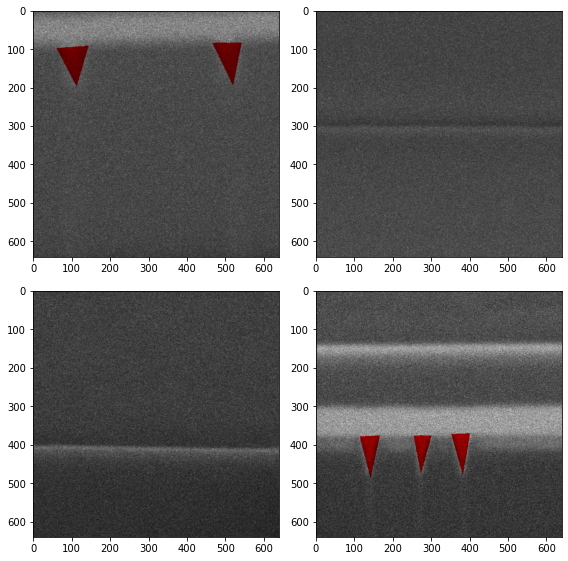

In [49]:
num_batches=2
plt.figure(figsize=(8,8))

for i, data in enumerate(loaders[0]['dataloader']):
    images, labels, mean, stdev = data
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    labels = np.around(labels.cpu().numpy()).astype('uint8')
    mean = mean.cpu().numpy()
    stdev = stdev.cpu().numpy()

    DisplayBatch(plt, i, batch_size, num_batches, images, labels, mean, stdev)

    if i >= num_batches-1:
        break

## Get COCO dataset

[torchdatasetutil.getcoco.getcoco](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/getcoco.py#L25) pulls and extracts the cocodata archives into a temporary directory.  It then populates the indicated object storage with these files.  Because of the large size of the coco dataset, it takes me about 30 minutes to download execute getcoco.


To load coco from the command line with default parameters, execute: 
```
python3 -m torchdatasetutil -getcoco
```

To load coco from python with default parametes, run the following python program:
```python
from pymlutil.s3 import s3store, Connect
from torchdatasetutil.getcoco import getcoco

s3, creds, s3def = Connect('creds.yaml')
getcoco(s3, s3def
```

## Using COCO dataset
[torchdatasetutil/cocostore](https://github.com/bhlarson/torchdatasetutil/blob/main/torchdatasetutil/cocostore.py) provides the following classes and functions:
- CocoStore: python iterator class over the coco dataset for inference
- CocoDataset: pytorch Dataset class providing data augmentation, cropping, and padding for training and test.
- CreateCocoLoaders: function providing an uniform interface to create PyTorch data loaders across dataests.

In [32]:
from torchdatasetutil.cocostore import CocoStore, CreateCocoLoaders

In [33]:
coco_dataset_train= 'data/coco/annotations/instances_train2017.json'
coco_train_image_path= 'data/coco/train2017'
coco_dataset_val= 'data/coco/annotations/instances_val2017.json'
coco_val_image_path= 'data/coco/val2017'
coco_class_dict= 'model/segmin/coco.json'

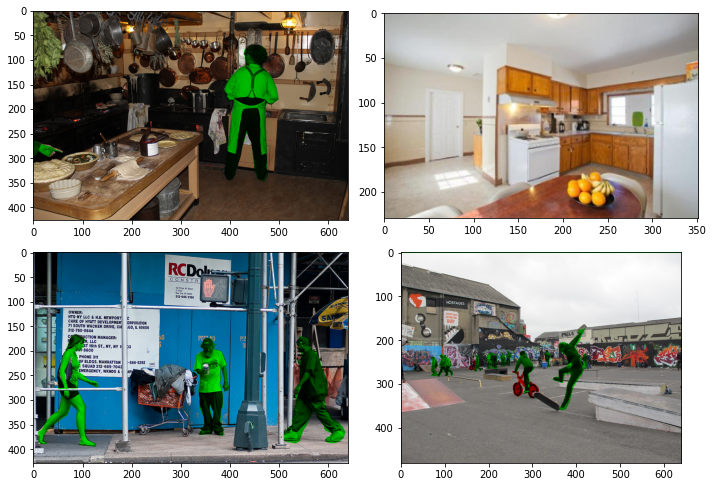

In [34]:
store = CocoStore(s3, bucket=bucket, 
                dataset_desc=coco_dataset_val, 
                image_paths=coco_val_image_path, 
                class_dictionary=coco_class_dict)
DisplayImages(store)

CreateCocoLoaders creates pytorch dataloaders defined by the loaders paramter.  By default this is the torch train and test datasets.  It returns a list contain an description and loaders for each dataset.

In [35]:
loaders = CreateCocoLoaders(s3, bucket, class_dict=coco_class_dict)
loaders

[{'set': 'train',
  'dataset': 'data/coco/annotations/instances_train2017.json',
  'image_path': 'data/coco/train2017',
  'enable_transform': True,
  'batches': 59143,
  'length': 118286,
  'dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f4c0d5459a0>},
 {'set': 'test',
  'dataset': 'data/coco/annotations/instances_val2017.json',
  'image_path': 'data/coco/val2017',
  'enable_transform': False,
  'batches': 2500,
  'length': 5000,
  'dataloader': <torch.utils.data.dataloader.DataLoader at 0x7f4c0d545100>}]

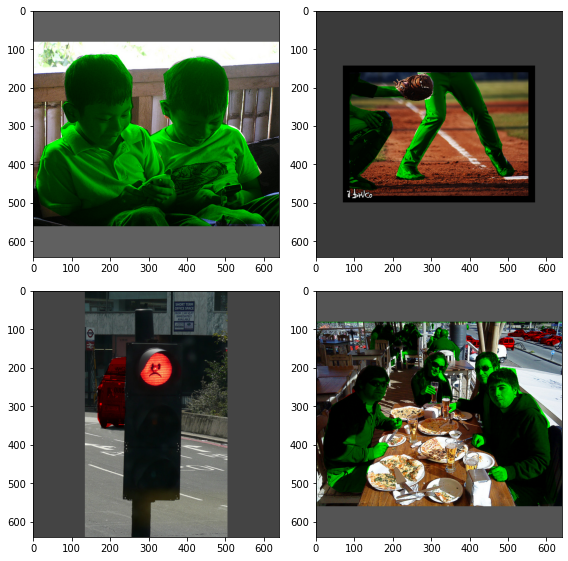

In [36]:
num_batches=2
plt.figure(figsize=(8,8))

for i, data in enumerate(loaders[1]['dataloader']):
    images, labels, mean, stdev = data
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    labels = np.around(labels.cpu().numpy()).astype('uint8')
    mean = mean.cpu().numpy()
    stdev = stdev.cpu().numpy()

    DisplayBatch(plt, i, batch_size, num_batches, images, labels, mean, stdev)

    if i >= num_batches-1:
        break

## Optical & Scene Flow Datasets

In [37]:
# ! python3 -m torchdatasetutil -getsceneflow

wget -O /tmp/tmpxi5z5epu/MPI-Sintel-complete.zip http://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip 
--2022-05-12 12:31:26--  http://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip
Resolving files.is.tue.mpg.de (files.is.tue.mpg.de)... 192.124.27.148
Connecting to files.is.tue.mpg.de (files.is.tue.mpg.de)|192.124.27.148|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip [following]
--2022-05-12 12:31:27--  https://files.is.tue.mpg.de/sintel/MPI-Sintel-complete.zip
Connecting to files.is.tue.mpg.de (files.is.tue.mpg.de)|192.124.27.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5627783629 (5.2G) [application/zip]
Saving to: ‘/tmp/tmpxi5z5epu/MPI-Sintel-complete.zip’

p/tmpxi5z5epu/MPI-S   3%[                    ] 208.83M  7.05MB/s    eta 11m 28s^C
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main